Author: Pascal, `pascal@bayesimpact.org`

Updated: `2018-02-11`

# BMO across Years

BMO means "Besoin en Main d'Oeuvre" and analyzes the working force needed (it is done by calling employers all over France). It's done once per year. See the [official website](http://bmo.pole-emploi.org/) for more details.

In Bob Emploi we want to display BMO data useful for the user. One way we want to show some context is to give the values for several years. Before doing that we want to make sure that no user would get surprised by the data for their specific case.

In [1]:
import glob
import os
from os import path
import re

import pandas
import seaborn as _

bmo_file_names = glob.glob(path.join(os.getenv('DATA_FOLDER'), 'bmo/bmo_*'))
bmo_df_dict = {}
for bmo_file_name in sorted(bmo_file_names):
    df = pandas.read_csv(bmo_file_name, dtype={'DEPARTEMENT_CODE': str})
    year = int(re.search(r'\d+', bmo_file_name).group())
    df['year'] = year
    bmo_df_dict[year] = df
    
sorted(bmo_df_dict.keys())

[2014, 2015, 2016, 2017]

Check that all the CSV files have the same structure.

In [2]:
def assert_all_the_same(dataframes, select_data_func, name='Values'):
    first = None
    for key, df in sorted(dataframes.items(), key=lambda kv: kv[0]):
        if first is None:
            first = select_data_func(df)
            continue
        other = select_data_func(df)
        if first - other:
            print('{} removed in {}:\n{}'.format(name, key, sorted(first - other)))
        if other - first:
            print('{} added in {}:\n{}'.format(name, key, sorted(other - first)))

assert_all_the_same(bmo_df_dict, lambda df: set(df.columns), name='Columns')

Columns removed in 2015:
['ROME_PROFESSION_CARD_CODE', 'ROME_PROFESSION_CARD_NAME']
Columns added in 2015:
['FAP_CODE', 'FAP_NAME']
Columns removed in 2016:
['ROME_PROFESSION_CARD_CODE', 'ROME_PROFESSION_CARD_NAME']
Columns added in 2016:
['FAP_CODE', 'FAP_NAME']
Columns removed in 2017:
['ROME_PROFESSION_CARD_CODE', 'ROME_PROFESSION_CARD_NAME']
Columns added in 2017:
['FAP_CODE', 'FAP_NAME']


Hmm, this is fishy, why would the BMO be by ROME? Let's check the values:

In [3]:
bmo_df_dict[2014].ROME_PROFESSION_CARD_CODE.unique()

array(['A0Z40', 'A0Z41', 'Q2Z90', 'V2Z91', 'R4Z93', 'D2Z41', 'A0Z42',
       'A1Z40', 'U1Z81', 'A0Z43', 'V2Z90', 'B6Z70', 'A1Z41', 'D1Z40',
       'L1Z60', 'A1Z42', 'A2Z90', 'A3Z40', 'B2Z40', 'A2Z70', 'A3Z41',
       'A3Z90', 'B0Z20', 'B0Z21', 'B2Z43', 'B2Z44', 'D2Z42', 'B1Z40',
       'V2Z93', 'E1Z42', 'W0Z80', 'Q2Z91', 'B2Z41', 'B2Z42', 'B4Z41',
       'B3Z20', 'B6Z72', 'M2Z92', 'B4Z44', 'B6Z71', 'B4Z43', 'G1Z80',
       'B7Z91', 'B4Z42', 'B5Z40', 'C0Z20', 'D0Z20', 'B6Z73', 'D4Z41',
       'D6Z70', 'G0B40', 'U0Z80', 'D2Z40', 'B7Z90', 'C2Z70', 'D3Z20',
       'C1Z40', 'H0Z91', 'J3Z43', 'D1Z41', 'C2Z71', 'C2Z80', 'E1Z41',
       'E0Z20', 'D6Z80', 'E0Z22', 'E0Z23', 'E0Z24', 'E0Z21', 'E1Z43',
       'G0A40', 'D6Z71', 'L2Z60', 'D4Z40', 'F3Z41', 'E1Z40', 'E2Z80',
       'F0Z20', 'E1Z46', 'E1Z47', 'F4Z20', 'G0A41', 'E2Z70', 'F1Z41',
       'F4Z41', 'F1Z40', 'F5Z70', 'F2Z20', 'E1Z44', 'G0A42', 'G0B41',
       'H0Z92', 'G0A43', 'G1Z70', 'M0Z60', 'L2Z61', 'L5Z90', 'L3Z80',
       'H0Z90', 'J0Z

OK, those are actually the FAP code, so we only need some columns renaming.

In [4]:
for df in bmo_df_dict.values():
    df.rename(columns={
            'ROME_PROFESSION_CARD_CODE': 'FAP_CODE',
            'ROME_PROFESSION_CARD_NAME': 'FAP_NAME',
        }, inplace=True)
assert_all_the_same(bmo_df_dict, lambda df: set(df.columns), name='Columns')

Let's check the column types:

In [5]:
for column in bmo_df_dict[2017].columns:
    assert_all_the_same(
        bmo_df_dict,
        lambda df: set([df.dtypes[column]]),
        name='Column Type for {}'.format(column))

Column Type for NB_DIFF_RECRUT_PROJECTS removed in 2015:
[dtype('O')]
Column Type for NB_DIFF_RECRUT_PROJECTS added in 2015:
[dtype('float64')]
Column Type for NB_DIFF_RECRUT_PROJECTS removed in 2016:
[dtype('O')]
Column Type for NB_DIFF_RECRUT_PROJECTS added in 2016:
[dtype('float64')]
Column Type for NB_RECRUT_PROJECTS removed in 2015:
[dtype('O')]
Column Type for NB_RECRUT_PROJECTS added in 2015:
[dtype('float64')]
Column Type for NB_RECRUT_PROJECTS removed in 2016:
[dtype('O')]
Column Type for NB_RECRUT_PROJECTS added in 2016:
[dtype('float64')]
Column Type for NB_SEASON_RECRUT_PROJECTS removed in 2015:
[dtype('O')]
Column Type for NB_SEASON_RECRUT_PROJECTS added in 2015:
[dtype('float64')]
Column Type for NB_SEASON_RECRUT_PROJECTS removed in 2016:
[dtype('O')]
Column Type for NB_SEASON_RECRUT_PROJECTS added in 2016:
[dtype('float64')]


Ouch, those numbers should all be floats not objects. Let's check some values:

In [6]:
bmo_df_dict[2014].NB_RECRUT_PROJECTS.head()

0    39,27177888
1    97,19287631
2             85
3    152,0641712
4    170,6651188
Name: NB_RECRUT_PROJECTS, dtype: object

In [7]:
for field in ('NB_RECRUT_PROJECTS', 'NB_DIFF_RECRUT_PROJECTS', 'NB_SEASON_RECRUT_PROJECTS'):
    for bmo_df in bmo_df_dict.values():
        bmo_df[field] = bmo_df[field].astype(str)\
            .str.replace(',', '.')\
            .str.replace(' ', '')\
            .replace('-', '0')\
            .astype(float)
bmo_df_dict[2014].NB_RECRUT_PROJECTS.head()

0     39.271779
1     97.192876
2     85.000000
3    152.064171
4    170.665119
Name: NB_RECRUT_PROJECTS, dtype: float64

After this cleanup, let's check again if the column types are consistant.

In [8]:
for column in bmo_df_dict[2017].columns:
    assert_all_the_same(
        bmo_df_dict,
        lambda df: set([df.dtypes[column]]),
        name='Column Type for {}'.format(column))

Cool, now column types are the same for each year.

Let's check if we have the same values in key fields, and do some point checks that were known to fail in previous versions:

In [9]:
assert_all_the_same(bmo_df_dict, lambda df: set(df.FAP_CODE.tolist()), name='FAP Codes')
assert_all_the_same(bmo_df_dict, lambda df: set(df.DEPARTEMENT_CODE.tolist()), name='Departement Codes')

fap_codes = set(bmo_df_dict[2016].FAP_CODE.tolist())
if 'A0Z40' not in fap_codes:
    print('FAP A0Z40 is missing.')

departement_codes = set(bmo_df_dict[2016].DEPARTEMENT_CODE.tolist())
if '2A' not in departement_codes:
    print('Département 2A is missing.')
if '01' not in departement_codes:
    print('Département 01 is missing.')

Departement Codes removed in 2015:
['1', '2', '3', '4', '5', '6', '7', '8', '9']
Departement Codes added in 2015:
['01', '02', '03', '04', '05', '06', '07', '08', '09']
Departement Codes removed in 2017:
['1', '2', '3', '4', '5', '6', '7', '8', '9']
Departement Codes added in 2017:
['01', '02', '03', '04', '05', '06', '07', '08', '09']
Département 01 is missing.


So it seems that some départements are not correctly set.

In [10]:
for _, df in bmo_df_dict.items():
    df['DEPARTEMENT_CODE'] = df.DEPARTEMENT_CODE.str.pad(2, fillchar='0')
assert_all_the_same(bmo_df_dict, lambda df: set(df['DEPARTEMENT_CODE'].tolist()), name='Departement Codes')
departement_codes = set(bmo_df_dict[2016].DEPARTEMENT_CODE.tolist())
assert('2A' in departement_codes)
assert('01' in departement_codes)

All seems good now: the Data Frame have the same columns, and the same set of values in the important columns.

Let's compare global stats.

In [11]:
bmo_df = pandas.concat(bmo_df_dict[year] for year in sorted(bmo_df_dict.keys()))

In [12]:
bmo_df.groupby(['year']).count()

,CATCHMENT_AREA_CODE,CATCHMENT_AREA_NAME,DEPARTEMENT_CODE,DEPARTEMENT_NAME,FAP_CODE,FAP_NAME,NB_DIFF_RECRUT_PROJECTS,NB_RECRUT_PROJECTS,NB_SEASON_RECRUT_PROJECTS,PROFESSION_FAMILY_CODE,PROFESSION_FAMILY_NAME,REGION_CODE,REGION_LIB
year,,,,,,,,,,,,,
2014,39095,39095,39095,39095,39095,39095,39095,39095,39095,39095,39095,39095,39095
2015,38732,38732,38732,38732,38732,38732,38732,38732,38732,38732,38732,38732,38732
2016,39501,39501,39501,39500,39501,39501,39501,39501,39501,39501,39501,39501,39501
2017,42429,42429,42429,42428,42429,42429,42429,42429,42429,42429,42429,42429,42429


In [13]:
bmo_df.groupby(['year']).sum()

,CATCHMENT_AREA_CODE,NB_DIFF_RECRUT_PROJECTS,NB_RECRUT_PROJECTS,NB_SEASON_RECRUT_PROJECTS,REGION_CODE
year,,,,,
2014,198679531,589953.269450,1.700541e+06,667037.379418,1981300
2015,194959082,563299.461139,1.739277e+06,683418.511234,1944091
2016,198859068,591507.400000,1.827271e+06,741914.580000,1982872
2017,212328291,740754.000000,1.976268e+06,775679.000000,2194196


In early 2017 when BMO 2017 was released, it had the same values as BMO 2016. Obviously this has changed now, so we can now use the data.

## Evolutions

Let's get an idea on how the BMO is evolving locally. Here are some basic questions:
* Which are the top 5 département with more hiring than last year (in %)?
* Which are the top 5 job families with more hiring than last year (in %)?

Let's try merging the data per local market. First let's check if we can merge on the "bassin d'emploi" level:

In [14]:
assert_all_the_same(bmo_df_dict, lambda df: set(df.CATCHMENT_AREA_CODE.tolist()), name='Catchment Area Codes')

Catchment Area Codes removed in 2015:
[9317, 9318]
Catchment Area Codes added in 2015:
[105, 106, 107, 108, 109, 110, 111, 112, 2316, 4317, 7329, 9326, 9331, 9332]
Catchment Area Codes removed in 2016:
[9309, 9310, 9317, 9318]
Catchment Area Codes added in 2016:
[105, 106, 107, 108, 109, 110, 111, 112, 2316, 4317, 7329, 9326, 9329, 9331, 9332, 9333]
Catchment Area Codes removed in 2017:
[1101, 1102, 1103, 1113, 1114, 1135, 1136, 1144, 1145, 1160, 1165, 1166, 1176, 1177, 1178, 1187, 1189, 1194, 1195, 9309, 9310, 9317, 9318]
Catchment Area Codes added in 2017:
[105, 106, 107, 108, 109, 110, 111, 112, 1107, 1108, 1109, 1115, 1116, 1117, 1118, 1119, 1124, 1125, 1126, 1127, 1128, 1129, 1137, 1138, 1139, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 2316, 4317, 7329, 9119, 9120, 9326, 9329, 9331, 9332, 9333]


Ooops no, it looks like the subdivision of départements has changed between the years, therefore we are going to first aggregate data at the départements level:

In [15]:
number_columns = ['NB_DIFF_RECRUT_PROJECTS', 'NB_RECRUT_PROJECTS', 'NB_SEASON_RECRUT_PROJECTS']
columns = list(set(bmo_df.columns) - set(number_columns) - {'CATCHMENT_AREA_CODE', 'CATCHMENT_AREA_NAME'})
bmo_df_by_departement = bmo_df.groupby(columns).sum()[number_columns].reset_index()
bmo_df_by_departement.head()

,REGION_LIB,year,FAP_CODE,DEPARTEMENT_NAME,DEPARTEMENT_CODE,REGION_CODE,FAP_NAME,PROFESSION_FAMILY_CODE,PROFESSION_FAMILY_NAME,NB_DIFF_RECRUT_PROJECTS,NB_RECRUT_PROJECTS,NB_SEASON_RECRUT_PROJECTS
0,ALSACE,2014,A0Z40,BAS-RHIN,67,42,Agriculteurs salariés (dont ouvriers agricoles...,Z,Autres métiers,142.806975,1011.194444,789.710943
1,ALSACE,2014,A0Z40,HAUT-RHIN,68,42,Agriculteurs salariés (dont ouvriers agricoles...,Z,Autres métiers,8.002828,196.928246,165.181621
2,ALSACE,2014,A0Z41,BAS-RHIN,67,42,Éleveurs salariés (dont soigneurs),Z,Autres métiers,7.974414,49.117383,17.567773
3,ALSACE,2014,A0Z41,HAUT-RHIN,68,42,Éleveurs salariés (dont soigneurs),Z,Autres métiers,0.000000,14.862626,7.431313
4,ALSACE,2014,A0Z42,BAS-RHIN,67,42,"Bûcherons, sylviculteurs salariés et agents fo...",Z,Autres métiers,1.015395,13.236659,12.221264


OK, now we can merge data per local market:

In [16]:
bmo_evolution = bmo_df_by_departement[bmo_df_by_departement.year == 2017]\
    .merge(
        bmo_df_by_departement[bmo_df_by_departement.year == 2016],
        on=['DEPARTEMENT_CODE', 'FAP_CODE'], how='outer', suffixes=['_2017', '_2016'])\
    .merge(
        bmo_df_by_departement[bmo_df_by_departement.year == 2015],
        on=['DEPARTEMENT_CODE', 'FAP_CODE'], how='outer', suffixes=['', '_2015'])\
    .merge(
        bmo_df_by_departement[bmo_df_by_departement.year == 2014],
        on=['DEPARTEMENT_CODE', 'FAP_CODE'], how='outer', suffixes=['', '_2014'])

### Evolution by Département

Show the distribution of hiring growth and volumes for départements: we do not expect to see any specific patterns, but this is a good way to have a glance to all départements at once.

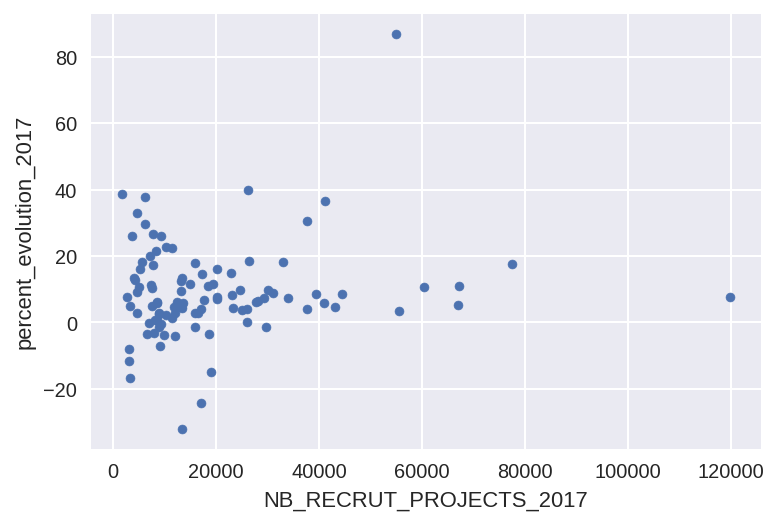

In [17]:
bmo_per_departement = bmo_evolution.groupby(['DEPARTEMENT_CODE', 'DEPARTEMENT_NAME']).sum()
bmo_per_departement['evolution_2017'] = bmo_per_departement.NB_RECRUT_PROJECTS_2017.div(bmo_per_departement.NB_RECRUT_PROJECTS_2016)
bmo_per_departement['percent_evolution_2017'] = (bmo_per_departement.evolution_2017 - 1) * 100
bmo_per_departement.plot(kind='scatter', x='NB_RECRUT_PROJECTS_2017', y='percent_evolution_2017');

There are few outliers. Let's first check the départements with the most hiring to understand all the outliers on the right:

In [18]:
dimensions_2017 = ['percent_evolution_2017', 'NB_RECRUT_PROJECTS_2017']
bmo_per_departement.sort_values('NB_RECRUT_PROJECTS_2017', ascending=False)[dimensions_2017].head(8)

,,percent_evolution_2017,NB_RECRUT_PROJECTS_2017
DEPARTEMENT_CODE,DEPARTEMENT_NAME,,
75,PARIS,7.740427,119867.0
13,BOUCHES-DU-RHÔNE,17.453258,77382.0
92,HAUTS-DE-SEINE,10.890171,67121.0
69,RHÔNE,5.104801,67022.0
59,NORD,10.735937,60314.0
33,GIRONDE,3.386186,55431.0
35,ILLE-ET-VILAINE,87.054160,54959.0
06,ALPES-MARITIMES,8.392574,44495.0


Obviously Paris is way bigger than the rest but still has a strong evolution (+7.7%). Then not fare, there is Hauts-de-Seine (just outside Paris, especially with \"La Défense\" district) which is big and still growing (+10.9%).

Marseille (Bouches-du-Rhône) that had a bad year in 2016 (see previous version of this notebook) is back in the game, and Rennes (Îlle-et-Vilaine) is having an exceptional year (+87.1%).

Now let's check the extreme changes:

In [19]:
bmo_per_departement['absolute_percent_evolution_2017'] = bmo_per_departement.percent_evolution_2017.abs()
bmo_per_departement.sort_values('absolute_percent_evolution_2017', ascending=False)[dimensions_2017].head()

,,percent_evolution_2017,NB_RECRUT_PROJECTS_2017
DEPARTEMENT_CODE,DEPARTEMENT_NAME,,
35,ILLE-ET-VILAINE,87.054160,54959.0
76,SEINE-MARITIME,39.893995,26122.0
23,CREUSE,38.626125,1634.0
61,ORNE,37.842427,6169.0
78,YVELINES,36.586902,41211.0


Weirdly Guadeloupe & Guyane (two oversee départements) have opposite but very strong changes. We could investigate a bit more if needed.

### Evolution by Job Family

Show the distribution of hiring growth and volumes for job families:

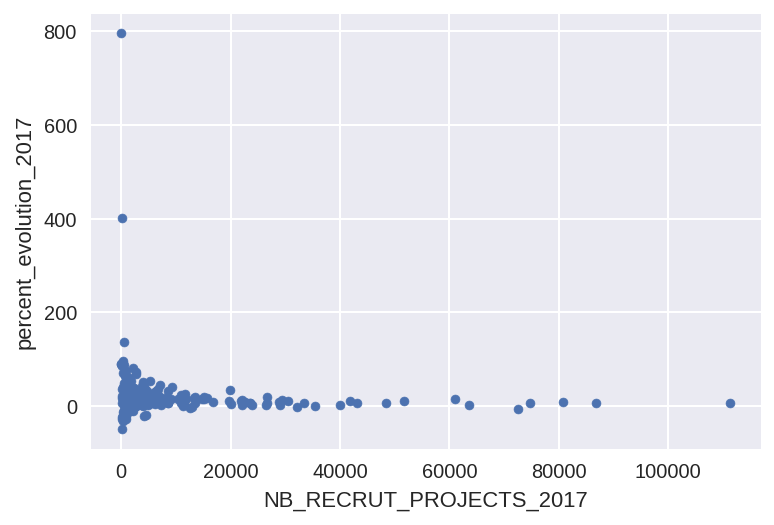

In [20]:
bmo_per_fap = bmo_evolution.groupby(['FAP_CODE', 'FAP_NAME']).sum()
bmo_per_fap['evolution_2017'] = bmo_per_fap.NB_RECRUT_PROJECTS_2017.div(bmo_per_fap.NB_RECRUT_PROJECTS_2016)
bmo_per_fap['percent_evolution_2017'] = (bmo_per_fap.evolution_2017 - 1) * 100
bmo_per_fap.plot(kind='scatter', x='NB_RECRUT_PROJECTS_2017', y='percent_evolution_2017');

A first conclusion is that only job families with few hiring have huge evolutions. However let's look at the job family that almost got +800%.

In [21]:
bmo_per_fap.sort_values('percent_evolution_2017', ascending=False)[dimensions_2017].head()

,,percent_evolution_2017,NB_RECRUT_PROJECTS_2017
FAP_CODE,FAP_NAME,,
W0Z91,Directeurs d'établissement scolaire et inspecteurs,794.819466,57.0
J4Z60,Contrôleurs des transports (personnels roulants),401.039021,217.0
B6Z70,Géomètres,136.104475,593.0
E1Z40,Pilotes d'installations lourdes des industries de transformation,94.972704,325.0
C2Z80,"Agents de maîtrise et assimilés en fabrication de matériel électrique, électronique",90.325139,72.0


So "school director" is a real hype in 2017…

Let's check the distribution again only focusing on job families with more than 20k hires in the year:

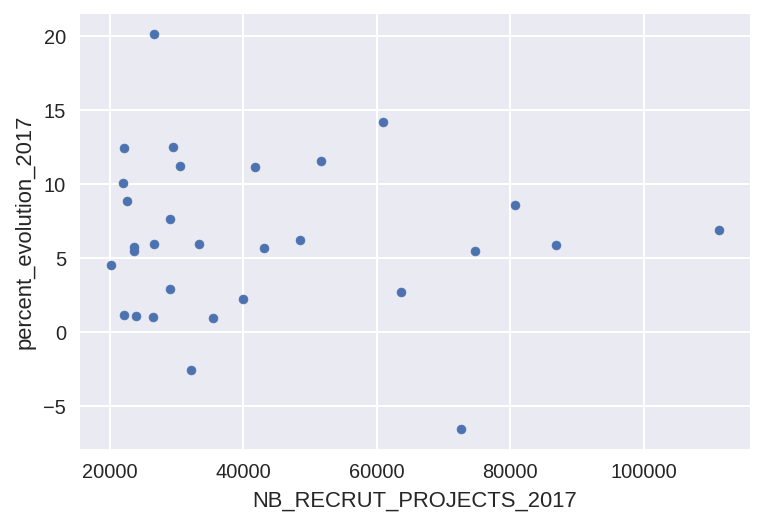

In [22]:
bmo_per_large_fap = bmo_per_fap[bmo_per_fap.NB_RECRUT_PROJECTS_2017 >= 20000]
bmo_per_large_fap.plot(kind='scatter', x='NB_RECRUT_PROJECTS_2017', y='percent_evolution_2017');

That looks reasonnable, let's check top growth:

In [23]:
bmo_per_large_fap.sort_values('percent_evolution_2017', ascending=False)[dimensions_2017].head()

,,percent_evolution_2017,NB_RECRUT_PROJECTS_2017
FAP_CODE,FAP_NAME,,
T1Z60,Employés de maison et personnels de ménage,20.148962,26646.0
T2A60,"Aides à domicile, aides ménagères, travailleuses familiales",14.201398,60965.0
R2Z80,Commerciaux (techniciens commerciaux en entreprise),12.512885,29417.0
R1Z60,Vendeurs en produits alimentaires,12.392717,22122.0
V0Z60,"Aides-soignants (aides médico-psychologiques, auxiliaires de puériculture, assistants médicaux)",11.521797,51670.0


It looks like clean Sales are pretty trendy…

## Conclusion

So BMO 2017 data looks pretty good and after a quick clean-up we were able to compare it with the previous years (2014, 2015 & 2016).

Some high level insights can be deduced from comparing these datasets. For instance, hiring is booming in Rennes and in really good shape in Paris, and in Paris' western suburbs. Also hiring is going really well for cleaning personnel as well as Sales and Caregivers.

Possible next steps:
* compare 2016 -> 2017 evolution with the evolution from 2015 -> 2016.
* go more local and understand at the "bassin d'emploi" level the local dynamics. E.g. find where a local decrease is compensated by a local increase next door so that we could advise our users to commute a bit more.
* compare flux and stock: the BMO is mixing new hires and replacements, but if we had a dataset with the number of currently employed persons we could distinguish local markets that are booming, and the ones that are becoming less stable (more hiring, but more firing as well).